# Code for Figure 5 
The notebook below generates all of the panels in Figure 5 of Lotthammer, Ginell, Griffith et al. 2023.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis

from scipy.signal import savgol_filter
import metapredict as meta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
from matplotlib.backends.backend_pdf import PdfPages

In [101]:
# define the directory where the proteome-wide data are held. These data can be obtained from
# https://github.com/holehouse-lab/shephard-data/tree/main/data/proteomes/human
rootdir = '/Users/alex/Dropbox/WASHU/Holehouse/tools/shephard/shephard_data_all/shephard-data/data/proteomes/human'



In [4]:
# build and annotate a human proteome
human_proteome = apis.uniprot.uniprot_fasta_to_proteome(f'{rootdir}/human_proteome_clean.fasta')
interfaces.si_domains.add_domains_from_file(human_proteome, '../fig_4/original/IDRs_with_properties_v2.tsv')
interfaces.si_tracks.add_tracks_from_file(human_proteome, 'shprd_re_vector_track.tsv',mode='values')


## Build background
The cell below cycles through each IDR in the human protein that's 51 residues or longer and then excises all the 51-residue fragments from those IDRs. these will serve as a null background for relative amino acid enrichment.

In [5]:
human_idr_background = []
for d in human_proteome.domains:
    if d.domain_type == 'IDR' and len(d) > 51:
        for idx in range(0,len(d)-50):
            human_idr_background.append(d.sequence[idx: idx+51])
        

## Identify proteins/subregions where IDRs are compact or expanded
The cell below cycles through each IDR and, if the IDR is over 50 residues we scan through each 51-residue fragment. This code constructs the set of proteome-wide sub-windows we will use to find IDRs with locally-compact or locall-expanded IDRs.


In [6]:
domains_with_local_collapse = set([])
domains_with_local_expansion = set([])


all_windows = []
proteins_searched = set([])

collapsed_domains = {}
expanded_domains = {}
all_domains = {}

# for each domain in the human proteome
for d in human_proteome.domains:

    # if that domain is an IDR and is over 50 residues in length
    if d.domain_type == 'IDR' and len(d) > 50:

        # we're going to excise out sub-regions which are particularly compact or expanded
        # (i.e. in botom/top 2.5% of the human proteome) and we're also going to save EVERY
        # subregion
            
        # note we use the +25 and -25 so we exclide the leading/lagging part of the track
        # which is just a reptition of the first value (see the notebook build_re_and_nu_track for 
        # the code used to build the tracks for more info)
        for s in range(d.start+25, d.end-25):
            if s > 51 and s < len(d.protein)-51:        
                
                # threshold at 2.5% most compact (44.317)
                if d.protein.get_track_values('re_vector')[s-1] < 44.317:
                    domains_with_local_collapse.add(d)
                    collapsed_domains[f"{d.protein.unique_ID}_"+ d.domain_name + f"_{s}"] = [d.protein.get_sequence_region(s-25,s+25), d.protein.get_track_values('re_vector')[s-1]] 
                
                # threshold at 97.5% most compact (57.318)
                if d.protein.get_track_values('re_vector')[s-1] > 57.318:
                    domains_with_local_expansion.add(d)
                    expanded_domains[f"{d.protein.unique_ID}_"+ d.domain_name + f"_{s}"] = [d.protein.get_sequence_region(s-25,s+25), d.protein.get_track_values('re_vector')[s-1]]

                # Get information on every single 51-residue subregion
                all_domains[f"{d.protein.unique_ID}_"+ d.domain_name + f"_{s}"] = [d.protein.get_sequence_region(s-25,s+25), d.protein.get_track_values('re_vector')[s-1]]

                # also generate a simple list which can be used to assess boundary values used to define
                # compact and expanded subregions.
                all_windows.append(d.protein.get_track_values('re_vector')[s-1])
                
    # because we're doing this on a per-IDR level, we use the proteins_searched
    # list to keep track of which protein sequences we've looked at
    if d.domain_type == 'IDR':
        proteins_searched.add(d.protein.unique_ID)
        



            


In [21]:
# show where upper/lower bounds are - these are bounds we use in the cell above so
# if you changed the data you'd need to run the cell above first, then run this cell
# to figure out what the bounds are, then re-run the cell above. This is obviously not
# ideal but given we don't expect to be re-defining the bounds
all_windows.sort()
print(f"Lower bound (Re): {all_windows[int(len(all_windows)*0.025)]} A")
print(f"Upper bound (Re): {all_windows[int(len(all_windows)*(1-0.025))]} A")
print(f"Found {len(all_windows)} windows across all human IDRs")

Lower bound (Re): 44.317 A
Upper bound (Re): 57.318 A
Found 2146400 windows across all human IDRs


## Calculate window parameters
Calculate sequence parameters for all windows. Note kappa calculation can be a bit slow over 2,146,400 sequences (3-4 minutes) so we keep it as an optional flag here.

In [8]:
calculate_kappa = False
all_fcr = [Protein(all_domains[x][0]).FCR for x in all_domains]
all_NCPR = [abs(Protein(all_domains[x][0]).NCPR) for x in all_domains]
all_NCPR_pro = [abs(Protein(all_domains[x][0]).NCPR) + Protein(all_domains[x][0]).fraction_proline for x in all_domains]
all_NCPR_no_abs = [Protein(all_domains[x][0]).NCPR for x in all_domains]

if calculate_kappa:
    all_kappa = [Protein(all_domains[x][0]).kappa for x in all_domains]

    # sanity check
    assert len(all_fcr) == len(all_kappa)

# sanity checks
assert len(all_fcr) == len(all_NCPR)
assert len(all_fcr) == len(all_NCPR_pro)
assert len(all_fcr) == len(all_NCPR_no_abs)

2146400

### Sanity check
What do 10 of the most expanded windows look like?

In [34]:
# Sanity check - what do the MOST expanded regions look like
mega_expand_thresh = 70
mega_expand = {}
for idx in all_domains:
    if all_domains[idx][1] > mega_expand_thresh:
        mega_expand[idx] = all_domains[idx]
for k in list(mega_expand.keys())[0:10]:
    Protein(mega_expand[k][0]).show_sequence(blocksize=51)        

In [43]:
# Sanity check - what do the MOST compact regions look like
mega_compact_thresh = 28
mega_compact = {}
for idx in all_domains:
    if all_domains[idx][1] < mega_compact_thresh:
        mega_compact[idx] = all_domains[idx]
for k in list(mega_compact.keys())[0:10]:
    Protein(mega_compact[k][0]).show_sequence(blocksize=51)        

In [143]:
all_re = [all_domains[x][1] for x in all_domains]

In [45]:
norm_window = 0.92*np.array(all_windows)/AnalyticalFRC('A'*51).get_mean_end_to_end_distance()

In [46]:
100*np.sum(norm_window < 1)/len(norm_window)

9.11083674990682

In [47]:
print(np.sum(norm_window > 1.2))
print(np.sum(norm_window < 1))
print(len(norm_window) - (np.sum(norm_window > 1.2) + np.sum(norm_window < 1)) )

92912
195555
1857933


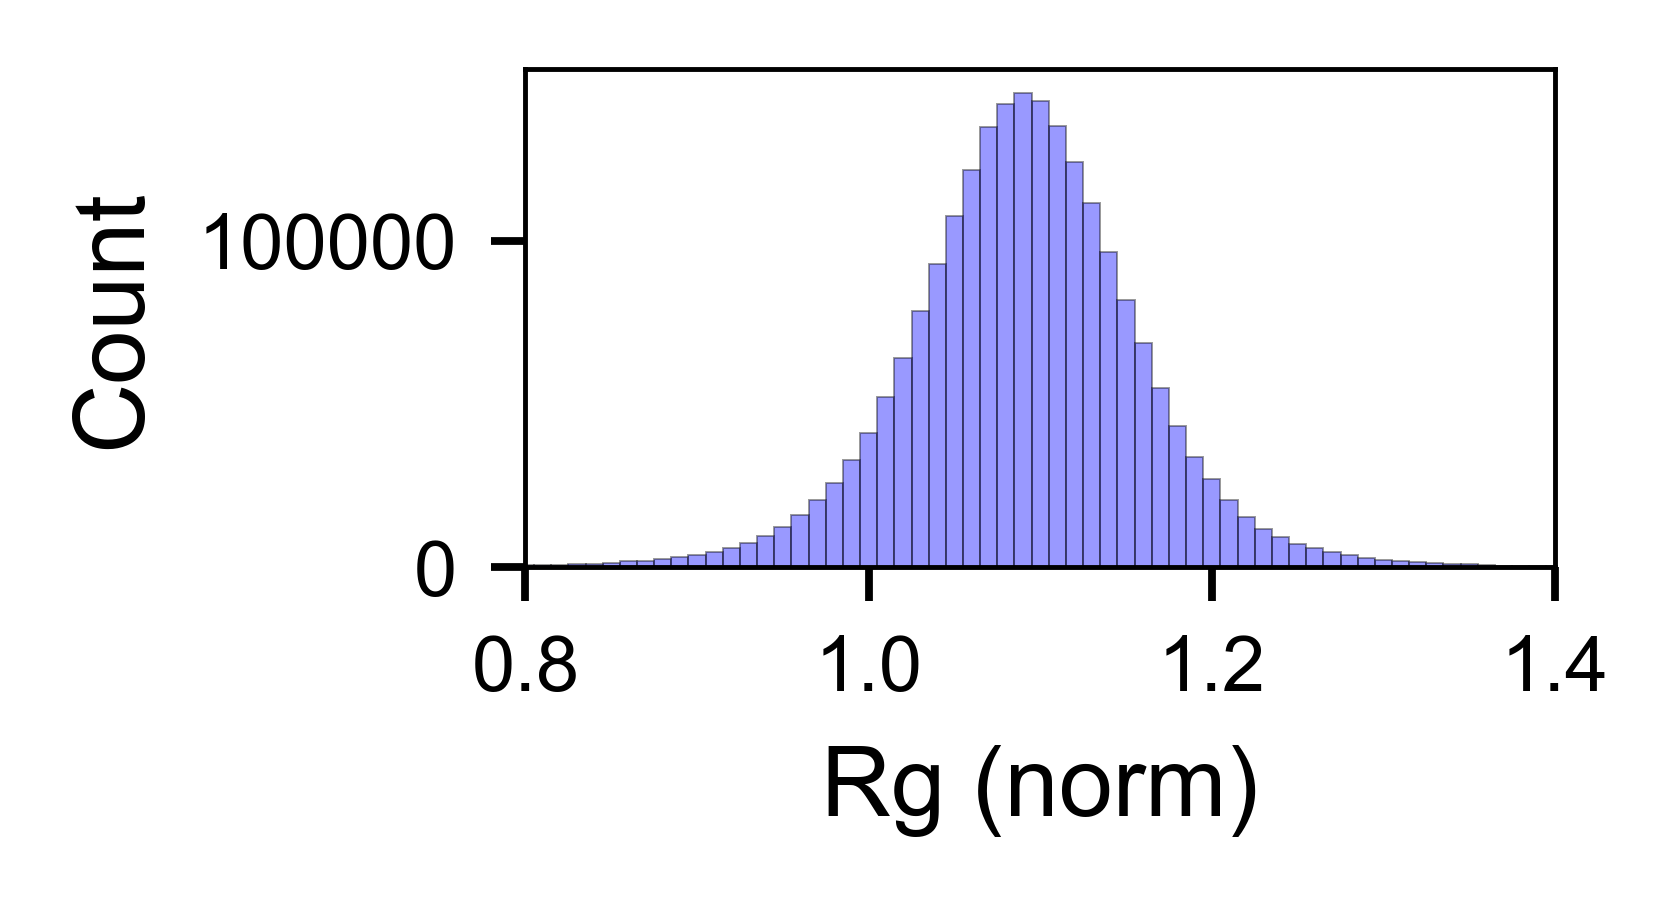

In [50]:
figure(None, (2.5,1.4), dpi=350)
bin_width=0.01
bins = np.arange(0.1,2.5,bin_width)

[a,b] = np.histogram(norm_window,bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='blue', alpha=0.4, linewidth=0.2, edgecolor='k') 
#plt.yscale('log')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xlim([0.8,1.4])
plt.ylabel('Count', fontsize=10)
plt.xlabel('Rg (norm)', fontsize=10)
#plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/human_idrs_rg_norm_histo.pdf')

## Identify proteins with compact windows
Next we scan through each of our collapsed and expands subregions and generate a counter for each protein to find proteins with many such subdomains

In [51]:
collapsed_count_per_protein = {}
for d in collapsed_domains:
    local = d.split('_')[0]
    if local not in collapsed_count_per_protein:
        collapsed_count_per_protein[local] = 1
    else:
        collapsed_count_per_protein[local] = collapsed_count_per_protein[local] +1

        
expanded_count_per_protein = {}
for d in expanded_domains:
    local = d.split('_')[0]
    if local not in expanded_count_per_protein:
        expanded_count_per_protein[local] = 1
    else:
        expanded_count_per_protein[local] = expanded_count_per_protein[local] +1
            

## Filter for proteins with many compact/expanded subregions
Next using a `count_threshold`, count we identify proteins with 10 or more compact or expanded subregions and highlight these as proteins with overly compact/expanded regions.

In [52]:
real_hits_collapsed = {}
real_hits_expanded = {}

count_threshold = 10

for p in expanded_count_per_protein:
    if expanded_count_per_protein[p] > count_threshold:
        real_hits_expanded[p] = expanded_count_per_protein[p]

for p in collapsed_count_per_protein:
    if collapsed_count_per_protein[p] > count_threshold:
        real_hits_collapsed[p] = collapsed_count_per_protein[p]
        

In [54]:
print(f"Found {len(real_hits_expanded)} proteins with 10+ expanded sub-sequences")
print(f"Found {len(real_hits_collapsed)} proteins with 10+ collapsed sub-sequences")

Found 1022 proteins with 10+ expanded sub-sequences
Found 1175 proteins with 10+ collapsed sub-sequences


## Build some more convenient dictionaries for further interrogation
We next build dictionaries (`uid2collapsed_domains` and `uid2expanded_domains`) which store the relevant domains in a way they can be looked up using a UniProt ID (UID) only.

In [56]:
uid2collapsed_domains = {}
uid2expanded_domains = {}

for x in collapsed_domains:
    uid = x.split('_')[0]
    if uid in real_hits_collapsed:
        if uid not in uid2collapsed_domains:
            uid2collapsed_domains[uid] = {}
        uid2collapsed_domains[uid][x]  = collapsed_domains[x]



for x in expanded_domains:
    uid = x.split('_')[0]
    if uid in real_hits_expanded:
        if uid not in uid2expanded_domains:
            uid2expanded_domains[uid] = {}
        uid2expanded_domains[uid][x]  = expanded_domains[x]


all_expanded_uids = list(uid2expanded_domains.keys())
all_collapsed_uids = list(uid2collapsed_domains.keys())

## Finally save the UniProt IDs out
We save the UniProt IDs of proteins with expanded or collapsed IDRs, along with our null background which corresponds to proteins with large IDRs (for statistical analysis down the line)

In [22]:
with open('out_data/UniProt_IDs_with_collased_IDR_regions.txt', 'w') as fh:
    for uid in all_collapsed_uids:
        fh.write(f"{uid}\n")

with open('out_data/UniProt_IDs_with_expanded_IDR_regions.txt', 'w') as fh:
    for uid in all_expanded_uids:
        fh.write(f"{uid}\n")

with open('out_data/background_proteins.txt', 'w') as fh:
    for uid in proteins_searched:
        fh.write(f"{uid}\n")
        

### Build background statistics 
Build information on what average fragments in human IDRs look like in terms of amino acid composition. We're going to use this as a background to normalize fractions from the compact and expanded windows in a second.

In [59]:
background_aa_fractions = []

for frag in human_idr_background:
    
    local_aa_fracts = Protein(frag).amino_acid_fractions
        
    tmp = []
    for aa in VALID_AMINO_ACIDS:
        tmp.append(local_aa_fracts[aa])
    background_aa_fractions.append(tmp)
    
    
    

In [60]:
# show average AA composition in 51-residue fragments
np.mean(background_aa_fractions,0)

array([0.07449788, 0.01441714, 0.04756619, 0.07591421, 0.02189078,
       0.07969607, 0.02410927, 0.02593033, 0.05338067, 0.07283406,
       0.01555617, 0.0318688 , 0.1052575 , 0.0515798 , 0.05611945,
       0.12078676, 0.05998167, 0.04589279, 0.00695704, 0.01576343])

## Computa AA fractions in compact and expanded cells
The code below calculates fraction of amino acids for the compact and expanded windows

In [61]:
aa_fractions_collapsed = []
aa_fractions_expanded = []


for idx in uid2collapsed_domains:
    x = uid2collapsed_domains[idx]
    
    for v in x.values():
        local_aa_fracts = Protein(v[0]).amino_acid_fractions
        
        tmp = []
        for aa in VALID_AMINO_ACIDS:
            tmp.append(local_aa_fracts[aa])
        aa_fractions_collapsed.append(tmp)
        
for idx in uid2expanded_domains:
    x = uid2expanded_domains[idx]
    
    for v in x.values():
        local_aa_fracts = Protein(v[0]).amino_acid_fractions
        
        tmp = []
        for aa in VALID_AMINO_ACIDS:
            tmp.append(local_aa_fracts[aa])
        aa_fractions_expanded.append(tmp)
    

## Calculate ratios
Finally, we calculate ratios for amino acids in compact and expanded IDRs

In [62]:

ratio_vals = np.mean(aa_fractions_collapsed,0)/np.mean(background_aa_fractions,0)
combined_list = sorted(zip(ratio_vals, VALID_AMINO_ACIDS), reverse=True)

reordered_ratio_collapsed = [number for number, string in combined_list]
reordered_AAs_collapsed = [string for number, string in combined_list]



ratio_vals = np.mean(aa_fractions_expanded,0)/np.mean(background_aa_fractions,0)
combined_list = sorted(zip(ratio_vals, VALID_AMINO_ACIDS), reverse=True)

reordered_ratio_expanded = [number for number, string in combined_list]
reordered_AAs_expanded = [string for number, string in combined_list]

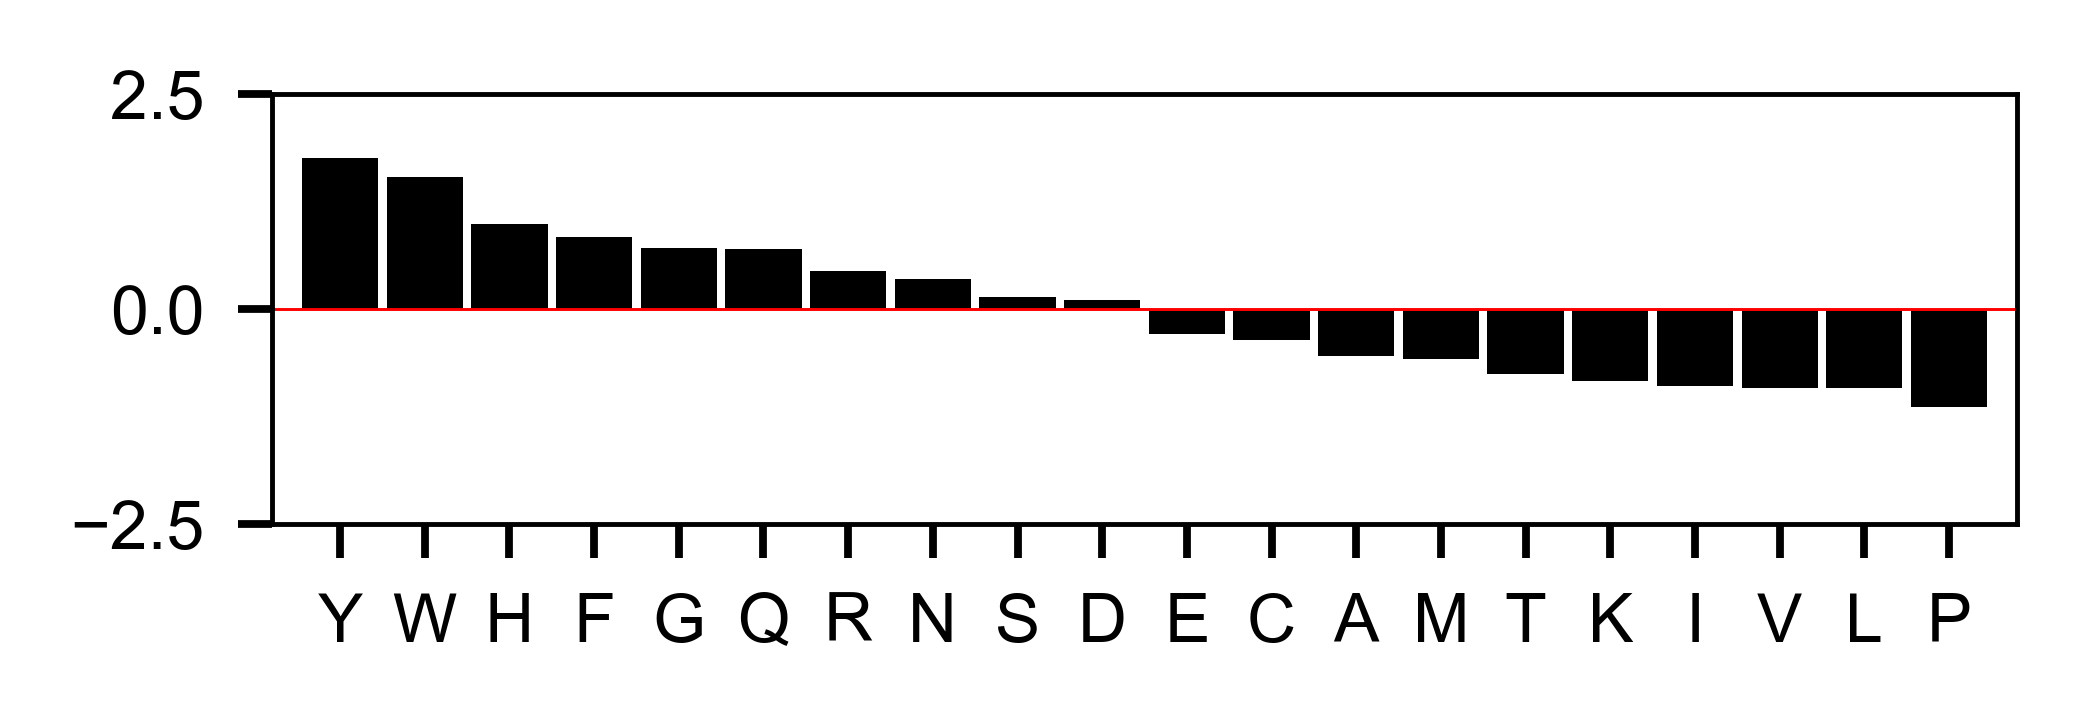

In [63]:


figure(None, (3.,1.1), dpi=350)
plt.bar(np.arange(1,21), np.log2(reordered_ratio_collapsed), width=0.9, color='k')
plt.xticks(np.arange(1,21), reordered_AAs_collapsed, fontsize=7)
plt.plot([0,21],[0,0], linewidth=0.3, color='r')
plt.xlim([0.2, 20.8])
plt.ylim([-2.5,2.5])
plt.yticks(fontsize=7)
print('')
plt.tight_layout()
plt.savefig('figures/compact_IDR_AA_fractions.pdf')

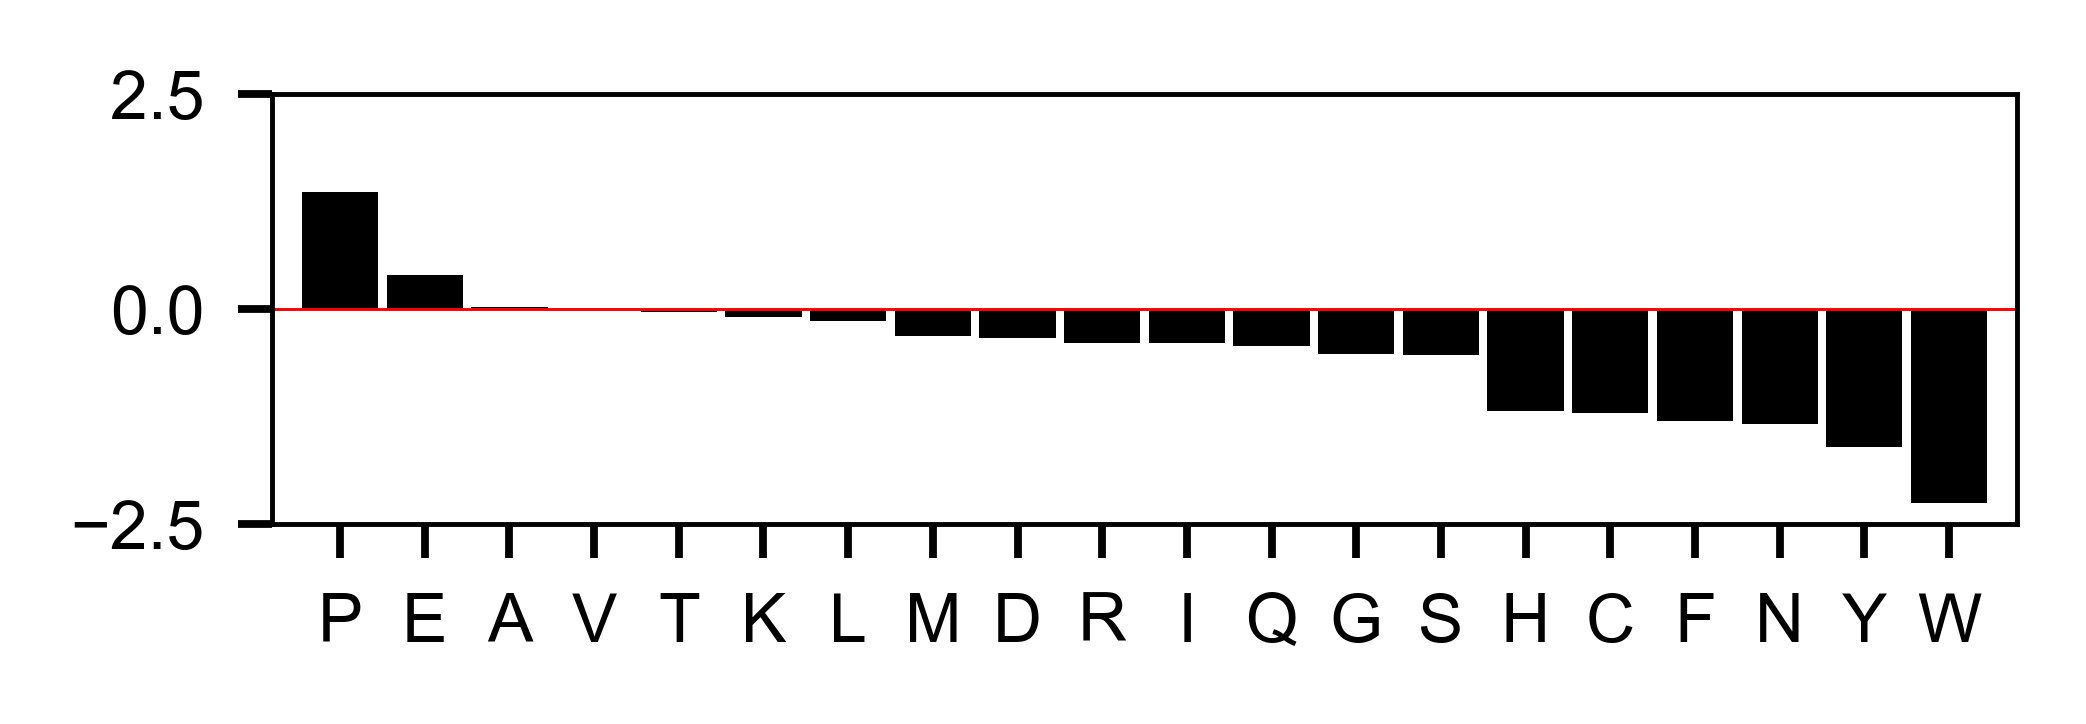

In [64]:


figure(None, (3.,1.1), dpi=350)
plt.bar(np.arange(1,21), np.log2(reordered_ratio_expanded), width=0.9, color='k')
plt.xticks(np.arange(1,21), reordered_AAs_expanded, fontsize=7)
plt.plot([0,21],[0,0], linewidth=0.3, color='r')
plt.xlim([0.2, 20.8])
plt.yticks(fontsize=7)
plt.ylim([-2.5,2.5])
print('')
plt.tight_layout()
plt.savefig('figures/expanded_IDR_AA_fractions.pdf')

### Generate per-protein figure for GIGYF1
The cells below generate linear local sequence analysis figures for GIGYF1

MAAETLNFGPEWLRALSGGGSVASPPPSPAMPKYKLADYRYGREEMLALYVKENKVPEELQDKEFAAVLQDEPLQPLALEPLTEEEQRNFSLSVNSVAVLRLMGKGAGPPLAGTSRGRGSTRSRGRGRGDSCFYQRSIEEGDGAFGRSPREIQRSQSWDDRGERRFEKSARRDGARCGFEEGGAGPRKEHARSDSENWRSLREEQEEEEEGSWRLGAGPRRDGDRWRSASPDGGPRSAGWREHGERRRKFEFDLRGDRGGCGEEEGRGGGGSSHLRRCRAPEGFEEDKDGLPEWCLDDEDEEMGTFDASGAFLPLKKGPKEPIPEEQELDFQGLEEEEEPSEGLEEEGPEAGGKELTPLPPQEEKSSSPSPLPTLGPLWGTNGDGDETAEKEPPAAEDDIRGIQLSPGVGSSAGPPGDLEDDEGLKHLQQEAEKLVASLQDSSLEEEQFTAAMQTQGLRHSAAATALPLSHGAARKWFYKDPQGEIQGPFTTQEMAEWFQAGYFSMSLLVKRGCDEGFQPLGEVIKMWGRVPFAPGPSPPPLLGNMDQERLKKQQELAAAALYQQLQHQQFLQLVSSRQLPQCALREKAALGDLTPPPPPPPQQQQQQLTAFLQQLQALKPPRGGDQNLLPTMSRSLSVPDSGRLWDVHTSASSQSGGEASLWDIPINSSTQGPILEQLQLQHKFQERREVELRAKREEEERKRREEKRRQQQQEEQKRRQEEEELFRRKHVRQQELLLKLLQQQQAVPVPPAPSSPPPLWAGLAKQGLSMKTLLELQLEGERQLHKQPPPREPARAQAPNHRVQLGGLGTAPLNQWVSEAGPLWGGPDKSGGGSSGLGLWEDTPKSGGSLVRGLGLKNSRSSPSLSDSYSHLSGRPIRKKTEEEEKLLKLLQGIPRPQDGFTQWCEQMLHTLSATGSLDVPMAVAILKEVESPYDVHDYIRSCLGDTLEAKEFAKQFLERRAKQKASQQRQQQQEAWLSSASLQTAFQANHSTKLGPGE

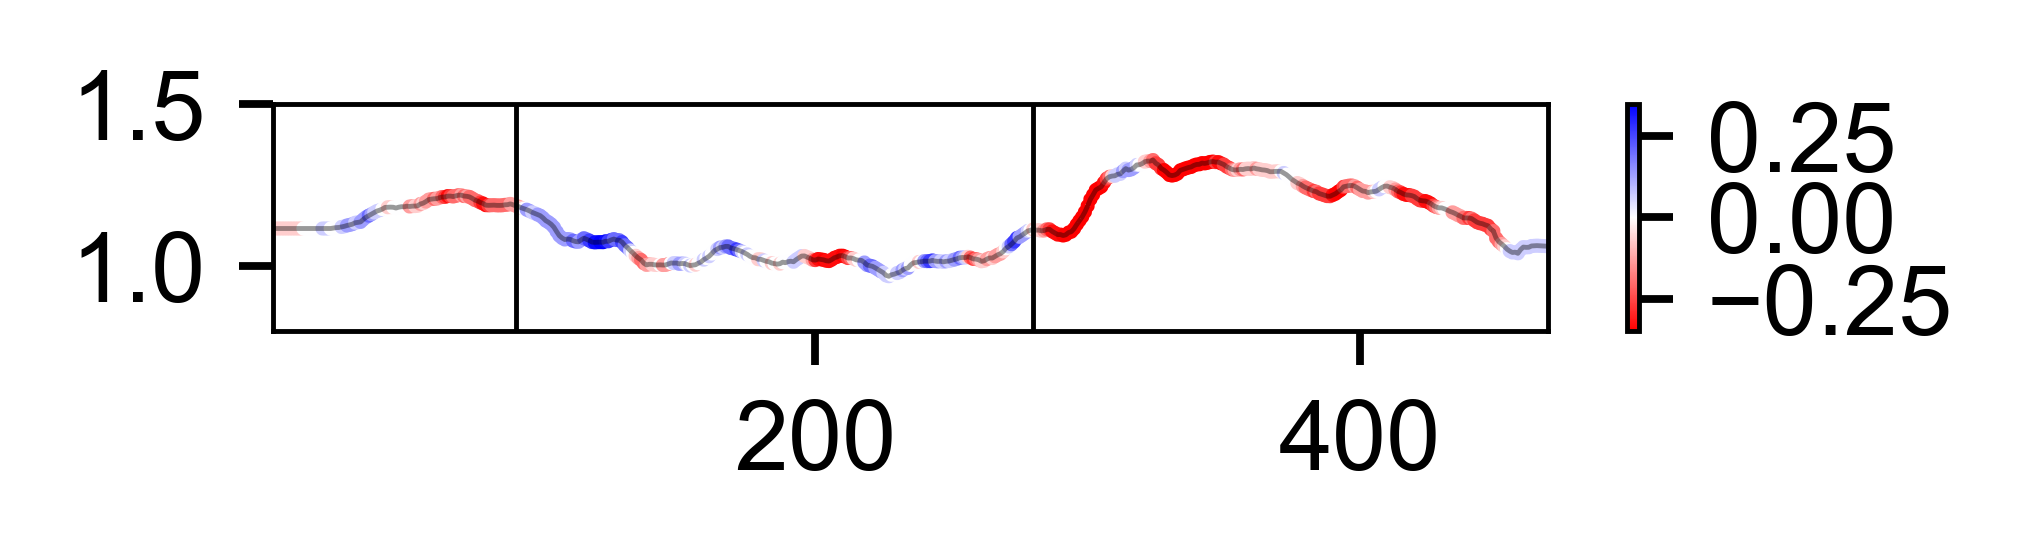

In [109]:
local_protein = human_proteome.protein('O75420')

# define the index for the IDR of interest
idr_idx = 0


# recompute normalization baseline
baseline = AnalyticalFRC('A'*51).get_mean_end_to_end_distance()

# get indices for the IDR of interest
idr1_boundaries = np.arange(local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end+1)

# get the IDR as its own Protein object
sparrow_d = Protein(local_protein.domains[idr_idx].sequence)

# calculate the linear NCRP profile along the sequence
linear_ncpr = sparrow_d.linear_sequence_profile('NCPR', window_size=15)

# get the linear local Re track
raw_re_vector = local_protein.domains[idr_idx].get_track_values('re_vector')

# smooth and normalize
smoothed_re_vector = savgol_filter(raw_re_vector,9,1)/baseline
normalized_raw_re_vector = raw_re_vector/baseline

# initialize the figure
figure(None, (3.,0.9), dpi=350)
ax = plt.gca()

# plot normalized re trace
plt.plot(idr1_boundaries, smoothed_re_vector, color='k', linewidth=0.5, alpha=0.4)

# uncomment this to sanity check smoothing isn't doing anything nefarious (it's not, but
# you should ALWAYS check!!!)
#plt.plot(idr1_boundaries, normalized_raw_re_vector, color='k', linewidth=0.2, alpha=0.3)

# overlay with colored trace
plt.scatter(idr1_boundaries, smoothed_re_vector, c=linear_ncpr, vmin=-0.35, vmax=0.35, s=0.2, cmap='bwr_r')


plt.xlim([local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end])
plt.colorbar()

plt.ylim([0.8,1.5])

ax.axvline(90, linewidth=0.5, color='k')
ax.axvline(280, linewidth=0.5, color='k')

plt.tight_layout()
plt.savefig('figures/GIGYF1_re_profile_IDR_1.pdf')
print(local_protein.sequence)

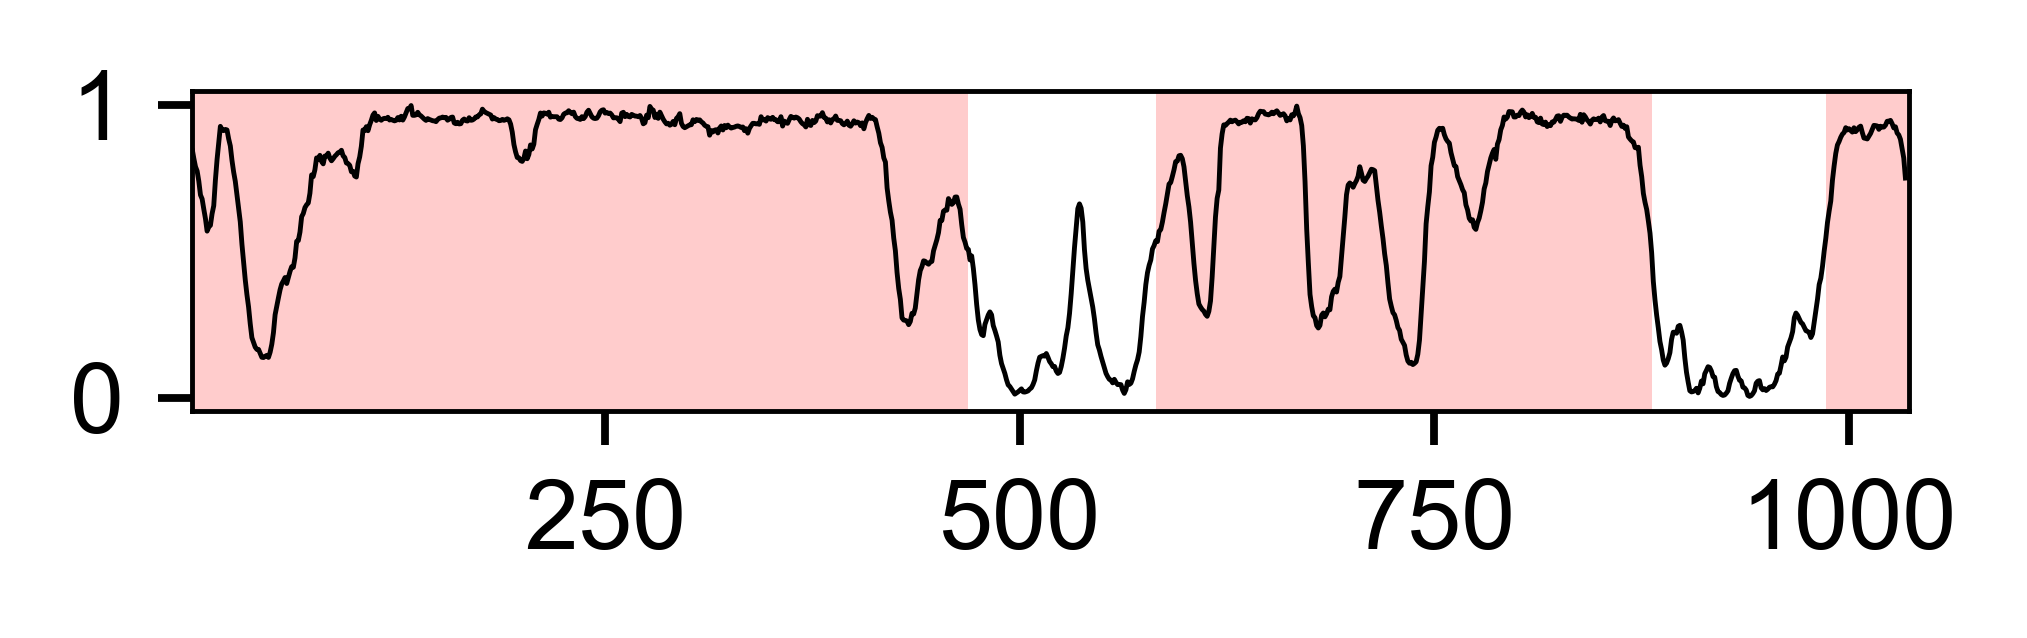

In [114]:
figure(None, (3.,1.), dpi=350)

local_protein = human_proteome.protein('O75420')
plt.plot(meta.predict_disorder(local_protein.sequence), color='k', linewidth=0.5)
ax = plt.gca()

plt.xlim([1,len(local_protein)+1])
for d in local_protein.domains:
    ax.axvspan(d.start, d.end, linewidth=0, alpha=0.2, color='r')
plt.tight_layout()
plt.savefig('figures/GIGYF1_disorder_profile_full_length.pdf')

### Generate per-protein figure for Son
The cells below generate linear local sequence analysis figures for Son

MATNIEQIFRSFVVSKFREIQQELSSGRNEGQLNGETNTPIEGNQAGDAAASARSLPNEEIVQKIEEVLSGVLDTELRYKPDLKEGSRKSRCVSVQTDPTDEIPTKKSKKHKKHKNKKKKKKKEKEKKYKRQPEESESKTKSHDDGNIDLESDSFLKFDSEPSAVALELPTRAFGPSETNESPAVVLEPPVVSMEVSEPHILETLKPATKTAELSVVSTSVISEQSEQSVAVMPEPSMTKILDSFAAAPVPTTTLVLKSSEPVVTMSVEYQMKSVLKSVESTSPEPSKIMLVEPPVAKVLEPSETLVVSSETPTEVYPEPSTSTTMDFPESSAIEALRLPEQPVDVPSEIADSSMTRPQELPELPKTTALELQESSVASAMELPGPPATSMPELQGPPVTPVLELPGPSATPVPELPGPLSTPVPELPGPPATAVPELPGPSVTPVPQLSQELPGLPAPSMGLEPPQEVPEPPVMAQELPGLPLVTAAVELPEQPAVTVAMELTEQPVTTTELEQPVGMTTVEHPGHPEVTTATGLLGQPEATMVLELPGQPVATTALELPGQPSVTGVPELPGLPSATRALELSGQPVATGALELPGPLMAAGALEFSGQSGAAGALELLGQPLATGVLELPGQPGAPELPGQPVATVALEISVQSVVTTSELSTMTVSQSLEVPSTTALESYNTVAQELPTTLVGETSVTVGVDPLMAPESHILASNTMETHILASNTMDSQMLASNTMDSQMLASNTMDSQMLASSTMDSQMLATSSMDSQMLATSSMDSQMLATSTMDSQMLATSSMDSQMLATSSMDSQMLATSSMDSQMLATSSMDSQMLATSTMDSQMLATSTMDSQMLATSSMDSQMLASGTMDSQMLASGTMDAQMLASGTMDAQMLASSTQDSAMLGSKSPDPYRLAQDPYRLAQDPYRLGHDPYRLGHDAYRLGQDPYRLGHDPYRLTPDPYRMSPRPYRIAPRSYRIAPRPYRLAPRPLMLASRRSMM

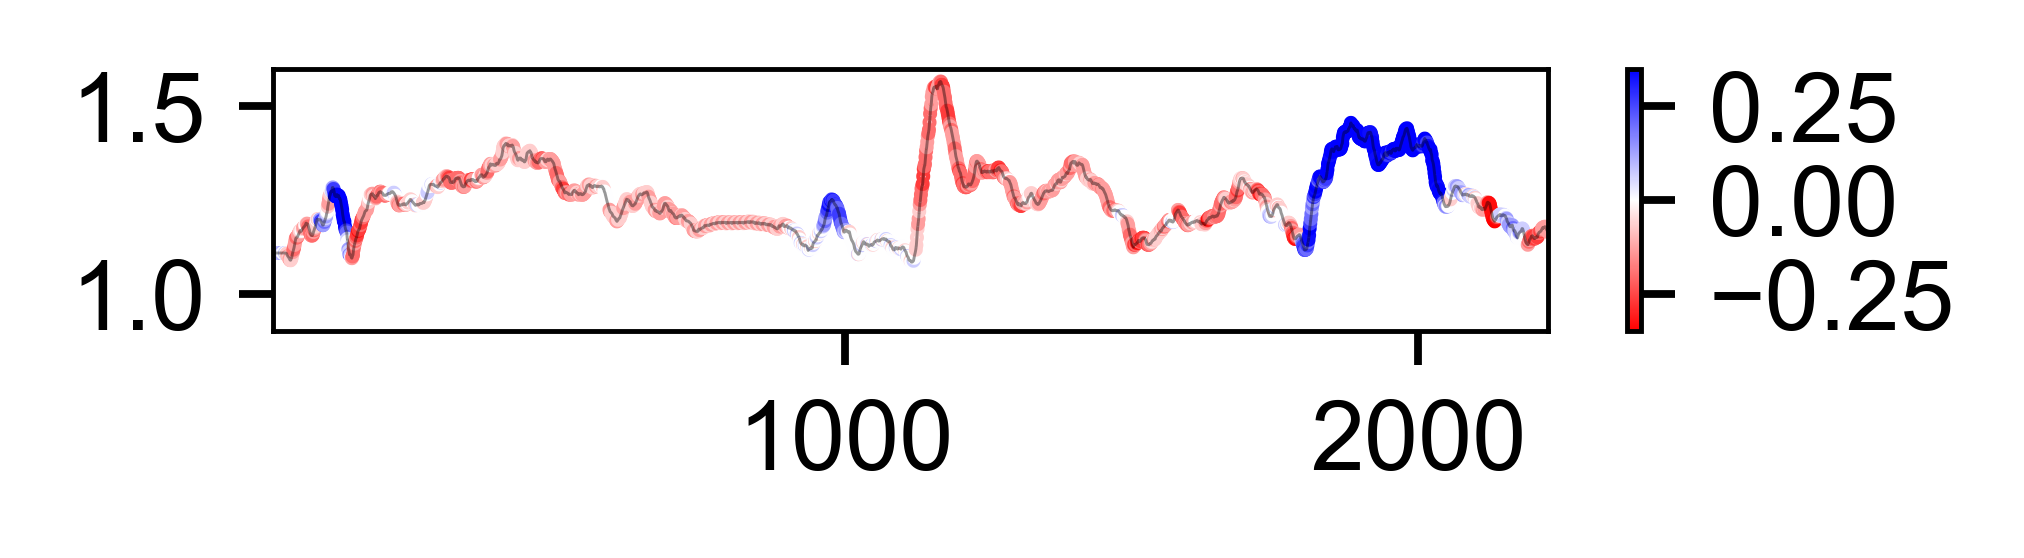

In [110]:
local_protein = human_proteome.protein('P18583')
idr_idx = 0


idr1_boundaries = np.arange(local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end+1)
baseline = AnalyticalFRC('A'*51).get_mean_end_to_end_distance()

sparrow_d = Protein(local_protein.domains[idr_idx].sequence)

linear_ncpr = sparrow_d.linear_sequence_profile('NCPR', window_size=15)

raw_re_vector = local_protein.domains[idr_idx].get_track_values('re_vector')
smoothed_re_vector = savgol_filter(raw_re_vector,9,1)/baseline


figure(None, (3.,0.9), dpi=350)
plt.plot(idr1_boundaries, smoothed_re_vector, color='k', linewidth=0.3, alpha=0.4)

plt.scatter(idr1_boundaries, smoothed_re_vector, c=linear_ncpr, vmin=-0.35, vmax=0.35, s=0.2, cmap='bwr_r')

plt.xlim([local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end])
plt.colorbar()
plt.ylim([0.9,1.6])


plt.tight_layout()
plt.savefig('figures/SON_re_profile_IDR_1.pdf')

print(local_protein.sequence)

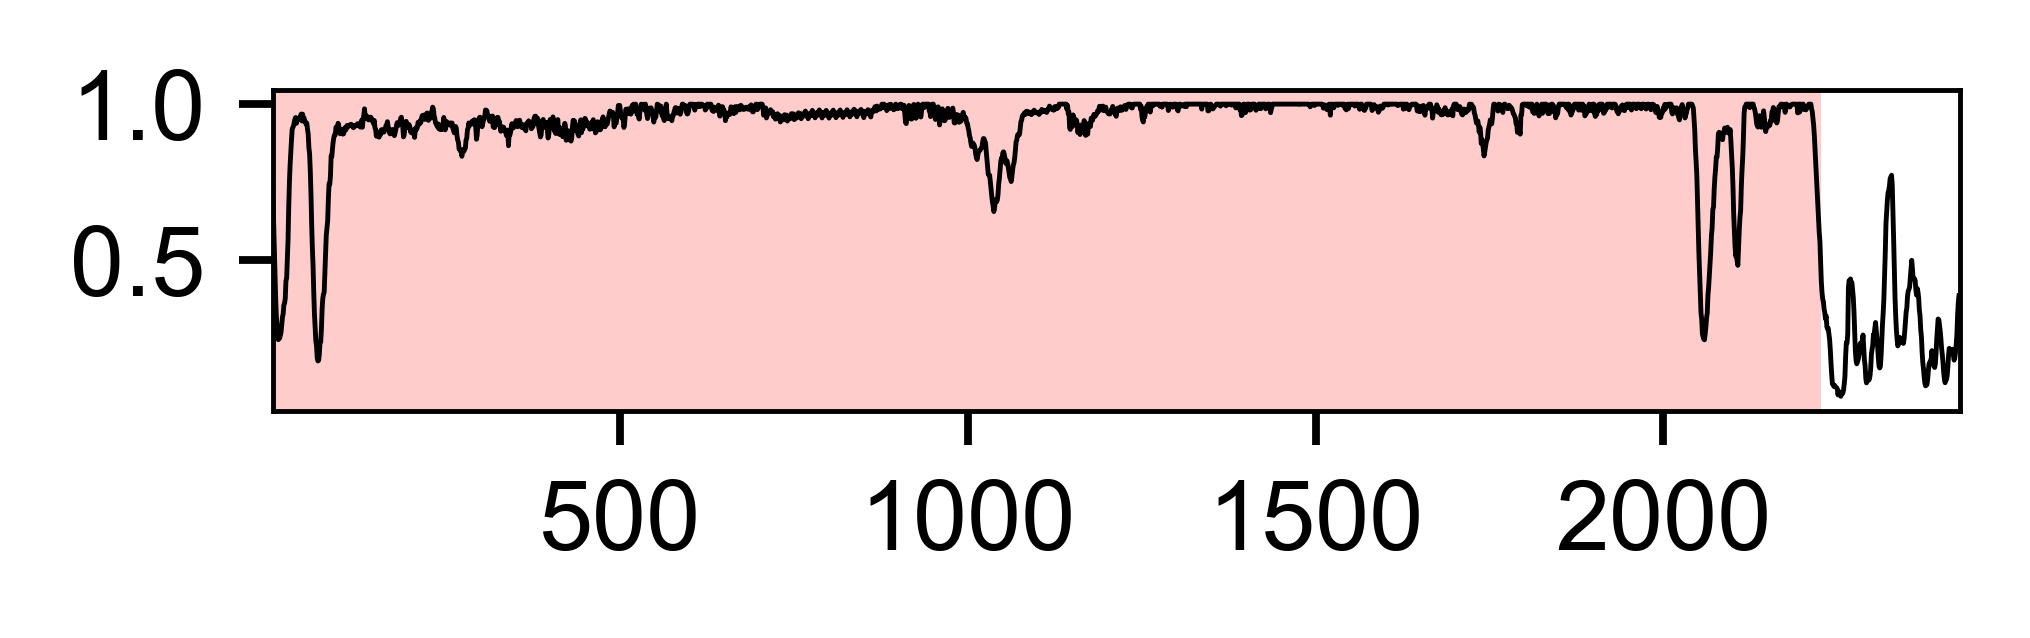

In [111]:
figure(None, (3.,1.), dpi=350)
local_protein = human_proteome.protein('P18583')
plt.plot(meta.predict_disorder(local_protein.sequence), color='k', linewidth=0.5)
ax = plt.gca()

plt.xlim([1,len(local_protein)+1])
ax.axvspan(local_protein.domains[0].start ,local_protein.domains[0].end, linewidth=0, alpha=0.2, color='r')
plt.tight_layout()
plt.savefig('figures/SON_disorder_profile_full_length.pdf')

## Bonus figure
* We also looked at alpha synuclein and clearly identified the C-terminal extended and acidic IDR as reported by previous biophysical characterization.
* We also looked at Tau and can see the clear positive and in isolation expanded C-terminal half

MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA


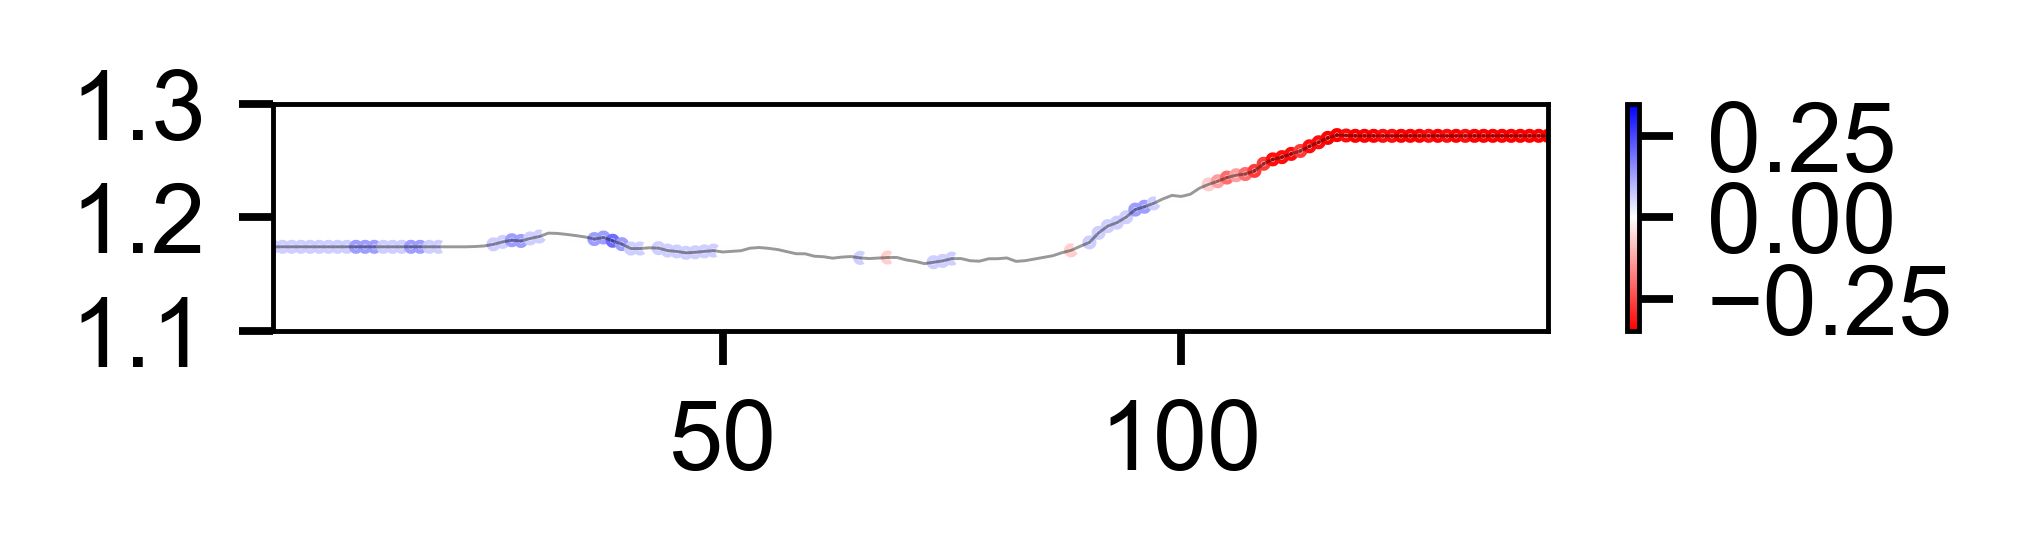

In [112]:
# Alpha synuclein (P37840)
#
local_protein = human_proteome.protein('P37840')
idr_idx = 0

figure(None, (3.,0.9), dpi=350)

idr1_boundaries = np.arange(local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end+1)
baseline = AnalyticalFRC('A'*51).get_mean_end_to_end_distance()

sparrow_d = Protein(local_protein.domains[idr_idx].sequence)

linear_ncpr = sparrow_d.linear_sequence_profile('NCPR', window_size=15)

raw_re_vector = local_protein.domains[idr_idx].get_track_values('re_vector')
smoothed_re_vector = savgol_filter(local_protein.domains[idr_idx].get_track_values('re_vector'),9,1)/baseline


plt.plot(idr1_boundaries, smoothed_re_vector, color='k', linewidth=0.3, alpha=0.4)

plt.scatter(idr1_boundaries, smoothed_re_vector, c=linear_ncpr, vmin=-0.35, vmax=0.35, s=0.2, cmap='bwr_r')

plt.xlim([local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end])
plt.colorbar()
#plt.xlim([200,1000])
plt.ylim([1.1,1.3])


plt.tight_layout()
plt.savefig('figures/alpha_synuclein_re_profile_IDR_1.pdf')

print(local_protein.sequence)

MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKESPLQTPTEDGSEEPGSETSDAKSTPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQEPESGKVVQEGFLREPGPPGLSHQLMSGMPGAPLLPEGPREATRQPSGTGPEDTEGGRHAPELLKHQLLGDLHQEGPPLKGAGGKERPGSKEEVDEDRDVDESSPQDSPPSKASPAQDGRPPQTAAREATSIPGFPAEGAIPLPVDFLSKVSTEIPASEPDGPSVGRAKGQDAPLEFTFHVEITPNVQKEQAHSEEHLGRAAFPGAPGEGPEARGPSLGEDTKEADLPEPSEKQPAAAPRGKPVSRVPQLKARMVSKSKDGTGSDDKKAKTSTRSSAKTLKNRPCLSPKHPTPGSSDPLIQPSSPAVCPEPPSSPKYVSSVTSRTGSSGAKEMKLKGADGKTKIATPRGAAPPGQKGQANATRIPAKTPPAPKTPPSSGEPPKSGDRSGYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAVVRTPPKSPSSAKSRLQTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIETHKLTFRENAKAKTDHGAEIVYKSPVVSGDTSPRHLSNVSSTGSIDMVDSPQLATLADEVSASLAKQGL


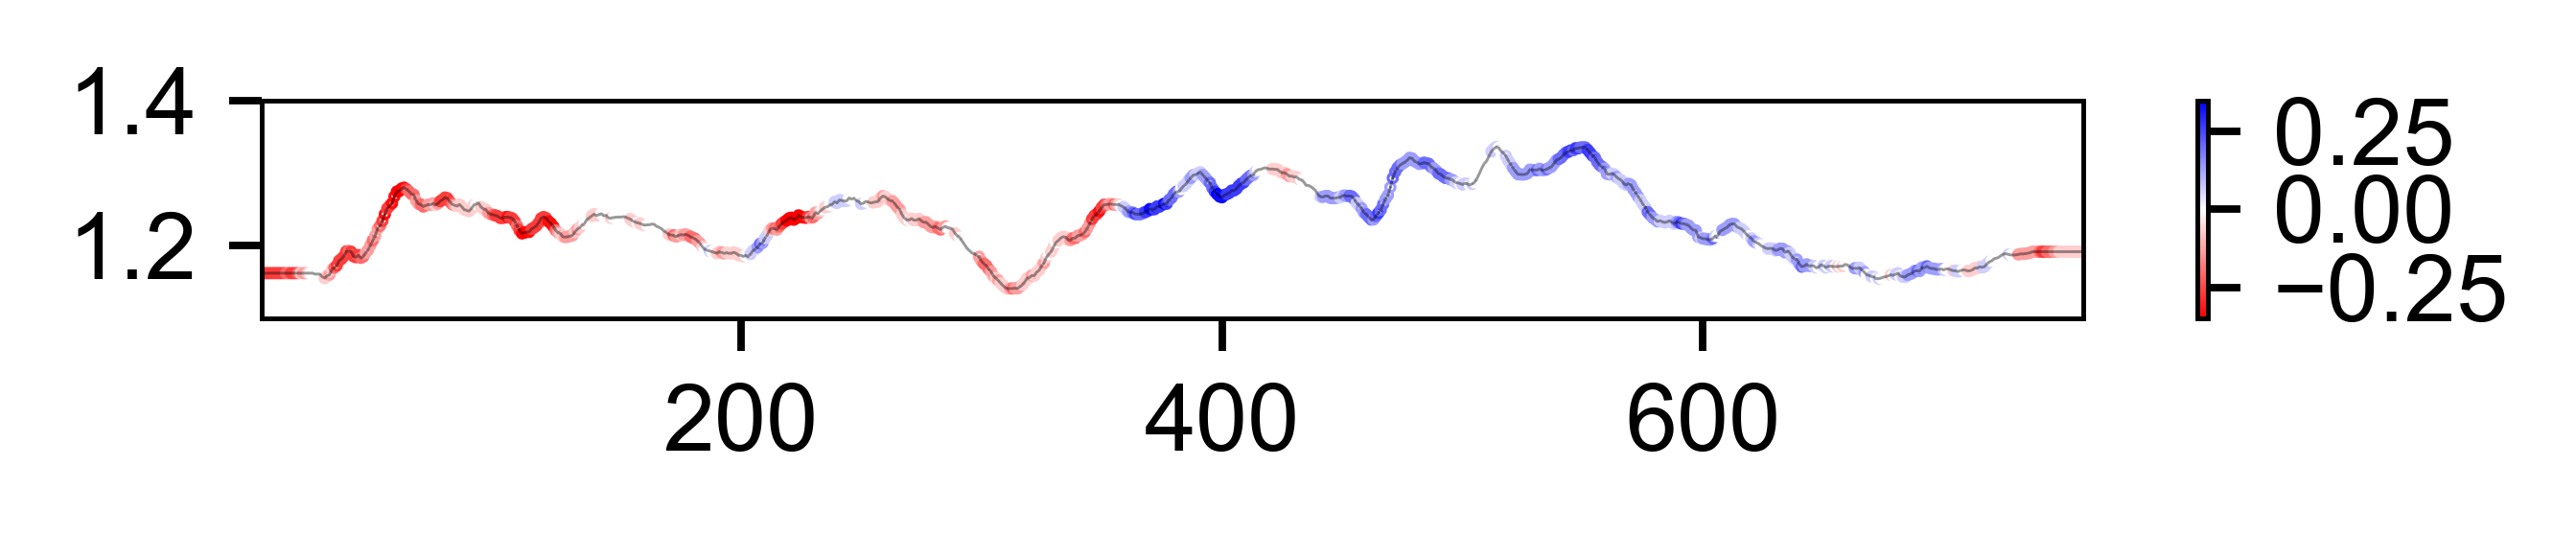

In [113]:
local_protein = human_proteome.protein('P10636')
idr_idx = 0

figure(None, (4.,0.9), dpi=350)

idr1_boundaries = np.arange(local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end+1)

sparrow_d = Protein(local_protein.domains[idr_idx].sequence)
linear_aro = sparrow_d.linear_sequence_profile('aromatic', window_size=15)
linear_ncpr = sparrow_d.linear_sequence_profile('NCPR', window_size=15)

raw_re_vector = local_protein.domains[idr_idx].get_track_values('re_vector')
smoothed_re_vector = savgol_filter(local_protein.domains[idr_idx].get_track_values('re_vector'),9,1)/AnalyticalFRC('A'*51).get_mean_end_to_end_distance()

#plt.plot(idr1_boundaries, raw_re_vector, color='k', linewidth=0.2)
plt.plot(idr1_boundaries, smoothed_re_vector, color='k', linewidth=0.3, alpha=0.4)

plt.scatter(idr1_boundaries, smoothed_re_vector, c=linear_ncpr, vmin=-0.35, vmax=0.35, s=0.1, cmap='bwr_r')
#plt.scatter(idr1_boundaries, smoothed_re_vector, c=smoothed_re_vector, vmin=40, vmax=65, s=0.4, cmap='PiYG')
#plt.scatter(idr1_boundaries, smoothed_re_vector, c=linear_aro, vmin=0, vmax=0.2, s=0.2, cmap='Oranges')

plt.xlim([local_protein.domains[idr_idx].start, local_protein.domains[idr_idx].end])
plt.colorbar()
#plt.xlim([200,1000])
plt.ylim([1.1,1.4])


plt.tight_layout()
plt.savefig('figures/tau_re_profile_IDR_1.pdf')

print(local_protein.sequence)